# Regresja - underfitting, overfitting, walidacja krzyżowa i regularyzacja

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import pandas as pd
from sklearn.model_selection import train_test_split

## Podział danych na zbiór treningowy i testowy

* **Dane treningowe** - dane używane do estymacji parametrów uczących modelu. W regresji wielomianowej będą to współczynniki stojące przy zmiennych podnoszonych do kolejnych potęg. Najczęściej używa się $70\%-80\%$ wszystkich danych do wyznaczenia zbioru treningowego.
* **Dane walidacyjne** - ok. $10\%$ danych. Danych walidacyjnych używa się do doboru najlepszych hiperparametrów dla naszego modelu w oparciu o pewną metrykę, jak np. MSE. Ważne jest to, że tych danych nie używa się do treningu!
* **Dane testowe** - ok. $10\%$ danych. Te dane służą do końcowej oceny naszego modelu. Tak, jak w przypadku danych walidacyjnych, ich także nie używa się do treningu. Na tym zbiorze nie powinno się dobierać "dobrych" hiperparametrów modelu. Ten zbiór służy jedynie do oceny jakości jego działania.

Do podziału danych na zbiór treningowy, walidacyjny i testowy służy funkcja _train_test_split_. Proszę zerknąć na jej działanie w kodzie w pierwszym zadaniu.

## Underfitting vs overfitting

W poniższym przykładzie zidentyfikujemy problem overfittingu i underfittingu, dopasowując krzywą wielomianową do danych syntetycznych.

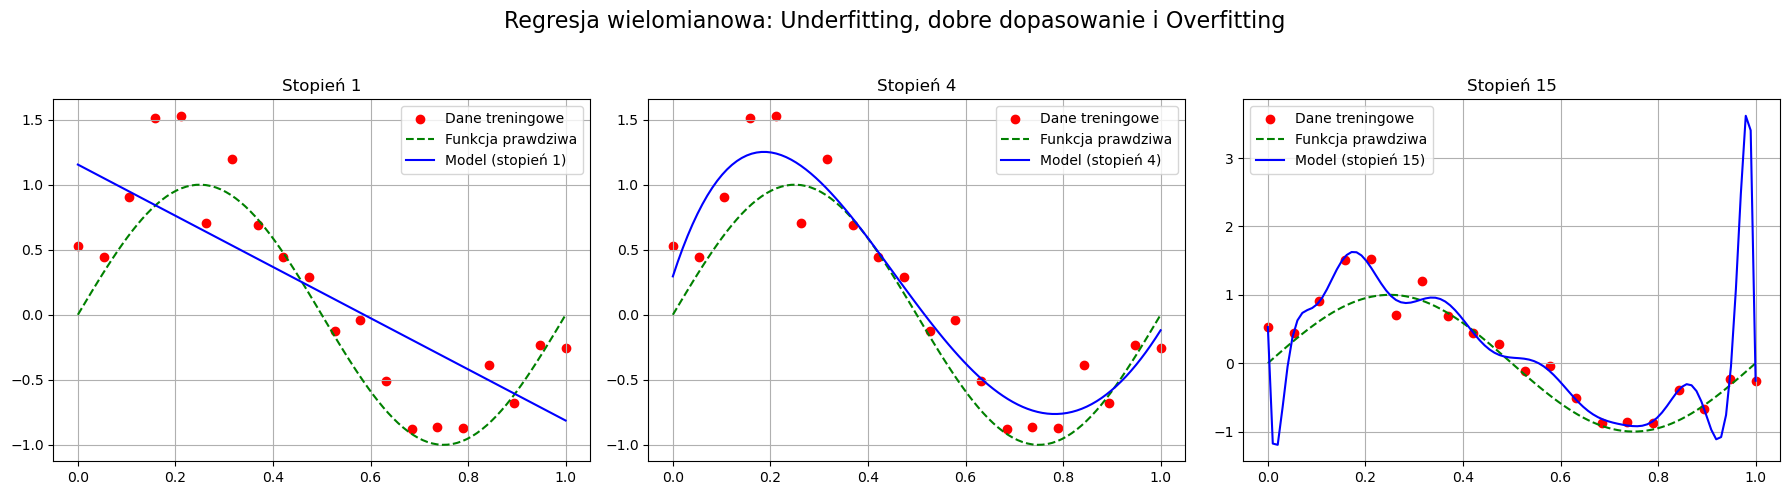

In [3]:
# 1. Generowanie danych
np.random.seed(0)
X = np.linspace(0, 1, 20)
y = np.sin(2 * np.pi * X) + np.random.normal(0, 0.3, X.shape)
X = X[:, np.newaxis]

# 2. Definicja stopni wielomianu do przetestowania
degrees = [1, 4, 15]

# 3. Rysowanie wykresów
plt.figure(figsize=(18, 5))
x_plot = np.linspace(0, 1, 100)[:, np.newaxis]

for i, degree in enumerate(degrees):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X, y)
    y_plot = model.predict(x_plot)

    plt.subplot(1, len(degrees), i + 1)
    plt.scatter(X, y, color='red', label='Dane treningowe')
    plt.plot(x_plot, np.sin(2 * np.pi * x_plot), label='Funkcja prawdziwa', color='green', linestyle='dashed')
    plt.plot(x_plot, y_plot, label=f'Model (stopień {degree})', color='blue')
    plt.title(f"Stopień {degree}")
    plt.legend()
    plt.grid(True)

plt.suptitle("Regresja wielomianowa: Underfitting, dobre dopasowanie i Overfitting", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Co możemy zaobserwować z powyższego wykresu?
* Jeżeli dopasujemy zbyt mały stopień wielomianu (np. przybliżamy krzywą reprezentowaną przez dane przez funkcję afiniczną), lub, bardziej ogólnie, dopasujemy model o małej pojemności, czyli taki, który ma bardzo ograniczoną zdolność do aproksymacji pewnych zależności, to mamy problem z tzw. **underfittingiem**.
* W drugą stronę, jeśli dopasujemy model bardzo złożony, jak np. regresję wielomianową z bardzo dużym stopniem wielomianu, to taka krzywa świetnie przybliży nam zależność obecną w danych na zbiorze treningowym, ale, niestety, na zbiorze testowym otrzymany wynik będzie kiepski. To oznacza, że dopasowany model "zapamiętał" dane treningowe, ale nie posiada zdolności generalizacji. Problem, o którym mowa, nazywa się **overfittingiem**. Jedną z najczęstszych przyczyn overfittingu jest niewystarczająca ilość danych treningowych.
* W praktyce musimy dobrać odpowiedni model do danego problemu tak, aby dopasowany model miał dobrą zdolność generalizacji.

### Zadanie nr 1 (4 punkty)
Użyj poniższego kodu do wygenerowania syntetycznych danych, a następnie do podzielenia tych danych na zbiór treningowy, walidacyjny i testowy.

In [6]:
# 1. Generowanie danych
np.random.seed(42)
X = np.linspace(0, 1, 100)
y = np.sin(2 * np.pi * X) + np.random.normal(0, 0.2, X.shape)
X = X[:, np.newaxis]

# 2. Podział danych (60% trening, 20% walidacja, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


Następnie:
1) Wytrenuj modele regresji liniowej o stopniach od 1 do 15 na zbiorze treningowym.
2) Dla każdego modelu oblicz błąd średniokwadratowy (MSE) na zbiorze walidacyjnym. Proszę pamiętać, że zbiór walidacyjny służy do doboru właściwych hiperparametrów modelu. U nas tym hiperparametrem będzie stopień wielomianu.
3) Narysuj wykresy:
    - MSE w zależności od stopnia wielomianu (na zbiorze treningowym i walidacyjnym).
    - Krzywą dopasowania najlepszego modelu (razem z danymi i prawdziwą funkcją).

## Walidacja krzyżowa
Gdy tworzymy model uczenia maszynowego, zależy nam na tym, żeby dobrze generalizował — czyli radził sobie nie tylko na danych treningowych, ale przede wszystkim na nowych, niewidzianych danych. Dlatego dzielimy dane na zbiór treningowy, walidacyjny i testowy. Dane dzielimy w sposób losowy, dlatego, z pewnym prawdopodobieństwem, możemy wylosować dane treningowe, które w pewnym sensie są "łatwe" bądź niereprezentatywne - nie oddające w pełni charakteru danych. W związku z tym, wprowadzamy tzw. **walidację krzyżową**.

Walidacja krzyżowa (ang. cross-validation) to technika, która pozwala lepiej ocenić jakość modelu, testując go na różnych podzbiorach danych. Dzięki temu zyskujemy bardziej wiarygodny wynik, niezależny od jednego, przypadkowego podziału. Algorytm:
1. Dzielimy dane na część treningową oraz testową. Następnie dzielimy dane treningowe na K równych części (tzw. foldy).
2. Powtarzamy punkt nr 1 K razy, tak że:
    - Za każdym razem inna część służy jako zbiór walidacyjny.
    - Pozostałe K-1 części służą jako zbiór treningowy.
    - Za każdym razem mierzymy jakoś dopasowania modelu za pomocą pewnych metryk, np. dokładność klasyfikacji, na każdym foldzie walidacyjnym.
    - Na koniec liczymy średnią z K wyników klasyfikacji (bo mamy K podziałów) z każdego foldu i to jest nasz finalny wynik.
3. Mierzymy dokładność modelu na zbiorze testowym.

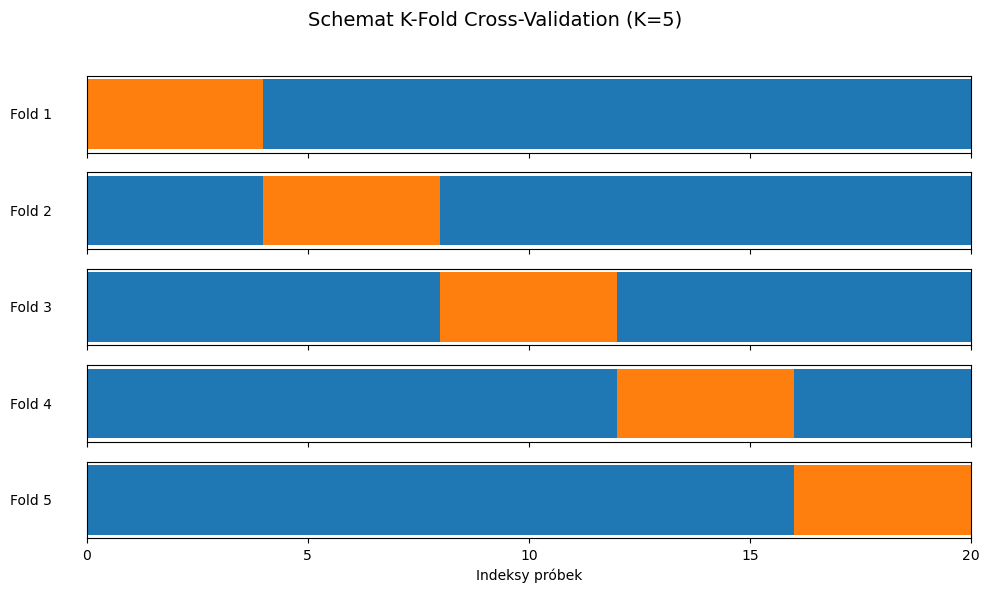

In [9]:
# Parametry
K = 5
n_samples = 20
fold_size = n_samples // K

# Kolory
colors = {
    'train': '#1f77b4',      # niebieski
    'val': '#ff7f0e',        # pomarańczowy
}

# Tworzenie wykresu
fig, axes = plt.subplots(K, 1, figsize=(10, 6), sharex=True)

for i in range(K):
    ax = axes[i]
    for j in range(K):
        start = j * fold_size
        end = (j + 1) * fold_size
        color = colors['val'] if j == i else colors['train']
        ax.broken_barh([(start, fold_size)], (0, 1), facecolors=color)
    
    ax.set_yticks([])
    ax.set_ylabel(f'Fold {i + 1}', rotation=0, labelpad=40, va='center')
    ax.set_xlim(0, n_samples)
    ax.set_xticks(range(0, n_samples + 1, 5))

axes[-1].set_xlabel('Indeksy próbek')
plt.suptitle('Schemat K-Fold Cross-Validation (K=5)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Zadanie nr 2 (3 punkty)
1) Dobierz optymalny stopień wielomianu za pomocą metody <tt>GridSearchCV</tt> z pakietu <tt>sklearn.model_selection</tt> dla danych reklamowych, obejmującym sprzedaż produktów i ich budżet reklamowy w trzech różnych mediach telewizyjnych, radiu, gazetach. Metoda ta pozwala na tzw. _grid search_, czyli zachłanne przeszukanie przestrzeni hiperparamatrów w celu identyfikacji tych najlepszych. Dodatkowo, w metodzie tej jest stosowana walidacja krzyżowa.
2) Narysuj MSE na zbiorze walidacyjnym (chodzi o średnią z metryki MSE policzoną ze wszystkich foldów) w zależności od stopnia wielomianu.

In [11]:
df_adv = pd.read_csv('https://raw.githubusercontent.com/przem85/bootcamp/master/statistics/Advertising.csv', index_col=0)
X = df_adv[['TV', 'radio','newspaper']]
y = df_adv['sales']
df_adv.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


## Regresja grzbietowa (ang. ridge regression)
**Regresja grzbietowa** to metoda regresji liniowej z regularyzacją $L^2$, która pozwala ograniczyć problem przeuczenia (overfittingu), zwłaszcza gdy dane są wielowymiarowe lub silnie skorelowane (kolinearność cech).

Regresja grzbietowa dodaje człon regularyzacyjny $L^2$ do funkcji kosztu, co ogranicza wartość bezwzględną wag (ich amplitduę) i zmniejsza wariancję modelu. Innymi słowy, rozwiązujemy nastepujący problem optymalizacyjny:

$$
\min_{\boldsymbol{w}} \ \| \boldsymbol{y} - X\boldsymbol{w} \|_2^2 + \lambda \| \boldsymbol{w} \|_2^2,
$$

gdzie:
  * $\lambda \geq 0$ — parametr regularyzacji (hiperparametr).
  * $\| \boldsymbol{w} \|_2^2 = \sum_{j=1}^{p} w_j^2$ — norma L2 wektora wag.

Dla $\lambda > 0$ funkcja kosztu jest ściśle wypukła, a rozwiązanie ma postać:

$$
\boldsymbol{w} = (X^\top X + \lambda I)^{-1} X^\top \boldsymbol{y},
$$

gdzie $I$ to macierz jednostkowa o wymiarach $p \times p$.

  Interpretacja regresji grzbietowej:
  * Im większa wartość $\lambda$, tym większa kara za duże wagi — model staje się prostszy (niższa wariancja, wyższy bias).
  * Dla $\lambda = 0$ odzyskujemy klasyczną regresję liniową.
  * Regresja grzbietowa działa dobrze przy współliniowości — dodanie $\lambda I$ do macierzy $X^\top X$ sprawia, że staje się ona odwracalna nawet, gdy $X^\top X$ nie jest.


Uwagi praktyczne:
* Dane powinny być uprzednio przeskalowane (standaryzacja cech), aby regularyzacja dobrze zadziałała (brak dominujących cech, których istnienie wynika bezposrednio ze skali danych).
* Dobór $\lambda$ zazwyczaj odbywa się za pomocą walidacji krzyżowej.

### Zadanie nr 3 (2 punkty)
Problem: Przewidywanie cen domów w Bostonie na podstawie różnych cech takich jak liczba pokoi, wiek budynku, odległość do centrum miasta itd. Użyj regresji grzbietowej, aby przewidzieć cenę domu. Użyj walidacji krzyżowej do wyboru optymalnego hiperparametru $\lambda$.

Dane: Boston

Proszę nie zapomnieć o podziale danych na zbiór treningowy, walidacyjny i testowy!

In [14]:
from sklearn.linear_model import Ridge

data_url = "http://lib.stat.cmu.edu/datasets/boston"
boston = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([boston.values[::2, :], boston.values[1::2, :2]])
target = boston.values[1::2, 2]

bos=pd.DataFrame(boston)
bos=pd.DataFrame(data)
feature_name = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO','B', 'LSTAT']
bos.columns = feature_name
bos['PRICE']=target # To jest nasza zmienna zależna
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Regresja LASSO (Least Absolute Shrinkage and Selection Operator)
**Regresja LASSO** to metoda regresji liniowej z regularyzacją $L^1$, która nie tylko ogranicza amplitudę wag, ale również potrafi **wyzerować nieistotne współczynniki**, dzięki czemu model wykonuje automatyczną selekcję cech (ang. feature selection).

W regresji LASSO dodajemy człon regularyzacyjny $L^1$ (norma Manhattan). Chcemy rozwiązać następujący problem optymalizacyjny:

$$
\min_{\boldsymbol{w}} \ \| \boldsymbol{y} - X\boldsymbol{w} \|_2^2 + \lambda \| \boldsymbol{w} \|_1.
$$

gdzie:
  * $\lambda \geq 0$ — parametr regularyzacji (hiperparametr).
  * $\| \boldsymbol{w} \|_1 = \sum_{j=1}^{p} |w_j|$ — norma L1 wektora wag.

Regularyzacja $L^1$ zachęca do wyzerowania niektórych współczynników $w_j$. Dzięki temu LASSO **wybiera tylko najistotniejsze cechy**. Dla odpowiednio dużego $\lambda$ niektóre wagi będą dokładnie równe 0. W przeciwieństwie do regresji grzbietowej, LASSO nie ma prostego rozwiązania analitycznego — trzeba używać metod numerycznych.


Uwagi:
* $\lambda = 0$ — odzyskujemy klasyczną regresję liniową.
* Małe $\lambda$ — delikatna regularyzacja, mało cech zerowanych.
* Duże $\lambda$ — więcej cech wyeliminowanych, uproszczony model.
* LASSO sprawdza się dobrze w sytuacjach, gdzie mamy wiele cech, ale tylko część z nich rzeczywiście wpływa na wynik (np. w bioinformatyce, NLP, finansach).
* Dane powinny być przeskalowane (np. standaryzacja), żeby regularyzacja była "sprawiedliwa" dla wszystkich cech.
* Optymalna wartość $\lambda$ zwykle dobierana jest za pomocą walidacji krzyżowej.

## Regresja Elastic Net

**Elastic Net** to metoda regresji liniowej, która łączy zalety regresji grzbietowej (Ridge) i regresji LASSO. Używa jednocześnie regularyzacji $L^1$ (selekcja cech) i $L^2$ (stabilizacja wag), co czyni ją skuteczną w problemach, gdzie cechy są liniowo zależne lub liczba cech jest większa niż liczba obserwacji.

Funkcja kosztu Elastic Net ma postać:

$$
\min_{\boldsymbol{w}} \ \| \boldsymbol{y} - X\boldsymbol{w} \|_2^2 + \lambda_1 \| \boldsymbol{w} \|_1 + \lambda_2 \| \boldsymbol{w} \|_2^2,
$$

gdzie:
  * $\boldsymbol{w}$ — wektor wag.
  * $\lambda_1, \lambda_2 \geq 0$ — hiperparametry kontrolujące siłę regularyzacji LASSO oraz regresji grzbietowej.

Elastic Net łączy zalety regresji grzbietowej oraz LASSO.

### Zadanie nr 4 (2 punkty)
Problem: Przewidywanie wydatków na energię elektryczną w zależności od różnych zmiennych (np. średnia temperatura, liczba mieszkańców, itp.). Użyj regresji LASSO oraz dobierz optymalny hiperparametr $\lambda$, używając walidacji krzyżowej.

Dane: Zbiór danych sklearn.datasets.fetch_openml('energy').

Proszę nie zapomnieć o podziale danych na zbiór treningowy, walidacyjny i testowy!

In [12]:
from sklearn.linear_model import Lasso
from sklearn.datasets import fetch_openml